In [67]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import math
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import AveragePooling2D, Dense, Flatten, Conv2D, MaxPool2D
from absl import app, flags
from easydict import EasyDict
from tqdm import tqdm


import matplotlib.pyplot as plt
import foolbox as fb
#rom foolbox import TensorFlowModel, accuracy, samples
#mport foolbox.attacks as fa
from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method, carlini_wagner_l2


# Foolbox

In [107]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
attack = fb.attacks.L2CarliniWagnerAttack(binary_search_steps = 10,
        steps = 10000,
        stepsize = 0.03,
        confidence = 0,
        initial_const = .1,
        abort_early = True)
adv_foolbox, clipped_adversarials, success = attack(
    fmodel,
    x_to_attack,
    y_to_attack,
    epsilons=None
)

# Cleverhans

In [117]:
clean_inputs = tf.reshape(x_to_attack, [10,28,28,1]);

adv_cleverhans = carlini_wagner_l2(model,clean_inputs,y=None,
               batch_size=10,
               clip_min=0.,
               clip_max=1.,
               binary_search_steps=10,
               max_iterations=10000,
               abort_early=False,
               confidence=0.,
               initial_const=.1,
               learning_rate=0.03)

# Eigene Implementation

In [84]:
adv_eigene = cw_2_eigene_implementierung(model,x_to_attack, steps=2000, const=1)

100%|██████████| 2000/2000 [00:32<00:00, 61.93it/s]


#### L2 Distance für Foolbox

In [125]:
l2_fb = [tf.norm(adv_foolbox[i]-x_to_attack[i]).numpy() for i in range(len(x_to_attack))]
l2_fb

[0.27698365,
 4.467263,
 3.0980809,
 1.4680731,
 0.52765006,
 2.3055704,
 1.6391438,
 4.9969068,
 3.2843807,
 1.7282153]

#### L2 Distance für Cleverhans

In [126]:
l2_ch = [tf.norm(adv_cleverhans[i].flatten()-x_to_attack[i]).numpy() for i in range(len(x_to_attack))]
l2_ch

[0.41441822,
 3.494786,
 3.8353348,
 2.3682518,
 0.80121773,
 2.360535,
 1.9128388,
 5.1769786,
 1.7254946,
 1.8560805]

#### L2 Distance für eigene Implementierung

In [127]:
l2_ei = [tf.norm(adv_eigene[i]-x_to_attack[i]).numpy() for i in range(len(x_to_attack))]
l2_ei

[0.36972156,
 1.0551662,
 0.88235486,
 0.42711136,
 0.39737734,
 0.96320105,
 0.4400873,
 1.1267165,
 0.53550375,
 0.8555029]

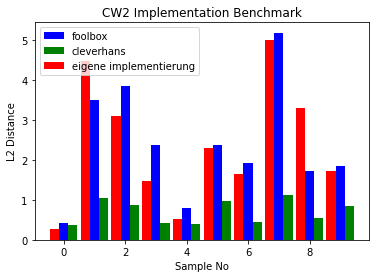

In [163]:
z = [x -.3 for x in range(10)]
y = [x +.3 for x in range(10)]
ax = plt.subplot(111)
w = 0.3
ax.bar(range(10),l2_ch,width=w, color='b', align='center',label='foolbox')
ax.bar(y,l2_ei, width=w, color='g', align='center',label='cleverhans')
ax.bar(z,l2_fb, width=w, color='r', align='center', label='eigene implementierung')
handles, labels = ax.get_legend_handles_labels()
ax.legend(labels )#loc='upper center')
ax.set(title='CW2 Implementation Benchmark',ylabel='L2 Distance', xlabel='Sample No')
plt.show()

In [123]:
res = fmodel(x_to_attack[:10])
adv_fb_res = fmodel(adv_foolbox)
adv_ch_res = fmodel(adv_cleverhans)
adv_eigen_res = fmodel(np.array(adv_eigene))

print(y_to_attack.numpy().tolist())
print([np.argmax(x) for x in res])
print([np.argmax(x) for x in adv_fb_res])
print([np.argmax(x) for x in adv_ch_res])
print([np.argmax(x) for x in adv_eigen_res])

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]
[5, 0, 4, 1, 9, 2, 1, 3, 1, 4]
[3, 2, 7, 8, 4, 8, 8, 7, 4, 7]
[3, 2, 1, 8, 4, 8, 8, 7, 4, 7]
[3, 2, 1, 8, 8, 8, 8, 7, 4, 7]


# CNN-5 Definition

In [3]:
shapes = {
    # 5x5 conv, 1 input, 6 outputs
    'conv_1': (5, 5, 1, 6),
    # 5x5 conv, 6 inputs, 16 outputs
    'conv_2': (5, 5, 6, 16),
    #5x5 conv as in paper, 16 inputs, 120 outputs
    'conv_3': (1, 1, 16, 120),
    # fully connected, 5*5*16 inputs, 120 outputs
    'dense_1': (5*5*16, 120),
    # fully connected, 120 inputs, 84 outputs
    'dense_2': (120, 84),
    # 84 inputs, 10 outputs (class prediction)
    'dense_3': (84, 10),
}
bias_shapes = {
    #output depth
    'conv_1': (6),
    'conv_2': (16),
    'dense_1': (120),
    'dense_2': (84),
    'dense_3': (10),
}

#conv2D with bias and relu activation

class CustomConvLayer(layers.Layer):

    def __init__(self, weights, mask, biases, strides, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = weights
        self.m = mask
        self.b = biases
        self.s = strides
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, tf.multiply(self.w, self.m), strides=[1, self.s, self.s, 1], padding=self.p,)# data_format='NCHW')
        x = tf.nn.bias_add(x, self.b,)# 'NC...')
        return tf.nn.tanh(x)
        

#Average Pooling Layer
class CustomPoolLayer(layers.Layer):
    
    def __init__(self, k=2, padding='valid'):#padding='VALID'):
        super(CustomPoolLayer, self).__init__()
        self.k = k
        self.p = padding
    
    def call(self, inputs):
#        return tf.keras.layers.AveragePooling2D(pool_size=(self.k, self.k), strides=None, padding=self.p, data_format='channels_first')(inputs)
        return tf.nn.avg_pool2d(inputs, ksize=[1, self.k, self.k,1], strides=[1, self.k, self.k, 1], padding=self.p,)# data_format='NCHW')
    

        
class CustomConvLayer(layers.Layer):

    def __init__(self, shape, bias, strides, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = self.add_weight(
            shape=shape,
            initializer='random_normal',
            trainable=True,
            name='w'
        )
        self.m = self.add_weight(
            shape=shape,
            initializer='ones',
            trainable=False,
            name='m'
        )
        self.b = self.add_weight(
            shape = (shape[-1]),
            initializer = 'zeros',
            trainable = True,
            name='b'
        )
        self.s = strides
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, tf.multiply(self.w, self.m), strides=[1, self.s, self.s, 1], padding=self.p,)# data_format='NCHW')
        x = tf.nn.bias_add(x, self.b,)# 'NC...')
        return tf.nn.tanh(x)

#Dense Layer with Bias
class CustomDenseLayer(layers.Layer):
    def __init__(self, shape, bias, activation = 'tanh'):
        super(CustomDenseLayer, self).__init__()
        self.w = self.add_weight(
            shape = shape,
            initializer='random_normal',
            trainable = True,
            name='w'
        )
        self.m = self.add_weight(
            shape = shape,
            initializer='ones',
            trainable = False,
            name='m'
        )
        self.b = self.add_weight(
            shape = (shape[-1]),
            initializer = 'zeros',
            trainable = True,
            name='b'
        )
        self.a = activation
        
        
    def call(self, inputs):
        x = tf.matmul(inputs, tf.multiply(self.w, self.m))
        x = tf.nn.bias_add(x, self.b)
        if self.a == 'tanh':
            return tf.nn.tanh(x)
        if self.a == 'softmax':
            return tf.nn.softmax(x)
        if self.a == None:
            return x
        
        
        
class CustomConvModel(tf.keras.Model):
    def __init__(self):
        super(CustomConvModel, self).__init__()
        self.conv1 = CustomConvLayer(shapes['conv_1'], True, 1, 'SAME')#'VALID')
        self.maxpool1 = CustomPoolLayer(k=2, padding='SAME')
        self.conv2 = CustomConvLayer(shapes['conv_2'], True, 1, 'VALID')
        self.maxpool2 = CustomPoolLayer(k=2, padding='VALID')

        self.dense1 = CustomDenseLayer(shapes['dense_1'], True, 'tanh')
        self.dense2 = CustomDenseLayer(shapes['dense_2'], True, 'tanh')
        self.dense3 = CustomDenseLayer(shapes['dense_3'], True, None)
        self.pre_softmax = None
        
    def call(self, inputs):
        x = tf.reshape(inputs, shape=[-1,28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = layers.Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x =  self.dense3(x)
        self.pre_softmax = x
        return tf.nn.softmax(x)
    
    

        


# Helper Functions

In [4]:
def train_model(model, to_convergence=True):
    if to_convergence == True:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=500,
            callbacks=[callback],
            validation_data=(x_test, y_test),
            )
    if to_convergence == False:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=100,
            callbacks=[callback],
            validation_data=(x_test, y_test),
            )
    return model
def initialize_base_model(index, experiment_name, save_weights=False):

    model = CustomConvModel()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False
                 )

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=x_train,
              y=y_train,
              batch_size=64,
              epochs=1,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )
    if save_weights == True:
        model.save_weights(f'./saved-weights/{experiment_name}-{index}')
    return model


# Load Data

In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255

x_to_attack = tf.convert_to_tensor(x_train[:10].reshape(10,28*28))
y_to_attack = tf.convert_to_tensor([y_train[:10]])[0];

# Initialize and Train Model

In [8]:
model = initialize_base_model(999,'')
train_model(model)

938/938 [==============================] - 3s 3ms/step - loss: 1.5928 - accuracy: 0.8909 - val_loss: 1.5168 - val_accuracy: 0.9490
Epoch 1/500
938/938 [==============================] - 3s 3ms/step - loss: 1.5051 - accuracy: 0.9595 - val_loss: 1.4944 - val_accuracy: 0.9686
Epoch 2/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4917 - accuracy: 0.9718 - val_loss: 1.4897 - val_accuracy: 0.9729
Epoch 3/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4859 - accuracy: 0.9770 - val_loss: 1.4828 - val_accuracy: 0.9800
Epoch 4/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4821 - accuracy: 0.9803 - val_loss: 1.4837 - val_accuracy: 0.9782
Epoch 5/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4794 - accuracy: 0.9830 - val_loss: 1.4802 - val_accuracy: 0.9810
Epoch 6/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4769 - accuracy: 0.9852 - val_loss: 1.4813 - val_accuracy: 0.9804
Epoch 7/500

# Eigene Implementation

In [83]:
def cw_2_eigene_implementierung(model, xs, const=1, steps=1000, learning_rate=.03, ):
    xa=[]
    
    for x in xs:
        w = tf.Variable(initial_value=tf.zeros(x.shape))
        
        show_adv = []
        optimizer = tf.keras.optimizers.Adam(.03)
        target = find_second_most_probable_class(get_logits(model,x))
        adv_image = .5 * (tf.tanh(w) + 1)
        best_adv_image = adv_image
        best_l2_dist = tf.norm(adv_image - x).numpy()
        for i in tqdm(range(steps)):
            with tf.GradientTape() as tape:

                adv_image = .5 * (tf.tanh(w) + 1)
                preds = model(adv_image)
                #const= CONST
                loss = loss_function(model= model, x=x, adv_image=adv_image, const=const, target=target)
                l2_distance = tf.norm(adv_image - x).numpy()
                if l2_distance < best_l2_dist and np.argmax(preds) == target:
                    best_adv_image = adv_image
                    best_l2_dist = l2_distance
                grads = tape.gradient(loss, w)
                optimizer.apply_gradients([(grads, w)])
                #print('l2 dist:', l2_distance)
                #print('target class: ',target)
                #print('pred of adv ex: ',np.argmax(model(adv_image)))
                #plt.figure()
                #plt.imshow(tf.reshape(adv_image, (28,28)))
                #plt.show()
                
        xa.append(best_adv_image)
    return xa

In [82]:
def loss_function(model, x, adv_image, const, target):
    l1 = tf.square(tf.norm(adv_image - x))
    logit_of_best_other = get_logit_of_best_except_target(model, adv_image, target)
    logit_of_target = get_logit_of_target(model, adv_image,target)
    l2 = const * tf.math.maximum(
        logit_of_best_other
        - logit_of_target
        , 0 )
    return l1 + l2


def find_second_most_probable_class(logits):
    logits = logits.numpy().flatten()
    return np.argpartition(logits,len(logits)-2)[len(logits)-2]

        


def get_logit_of_best_except_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    #print('all_logits', all_logits)
    most_probable_class = tf.math.argmax(all_logits)
    second_most_probable_class = find_second_most_probable_class(all_logits)
    if target == most_probable_class: 
        return all_logits[second_most_probable_class ]
    if target != most_probable_class: 
        return all_logits[most_probable_class ]

def get_logit_of_target(model, adv_x, target):
    all_logits = get_logits(model, adv_x)
    return all_logits[target]

def get_logits(model, x):
    model(x)
    return model.pre_softmax[0]
    


# Don't use all available GPU Memory

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * x of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs
